## Modeling the Indian Railway as a Network: Route Clustering and Zone Analysis


### Project Objective
The goal of this project is to study the Indian Railway Network through the lens of network science by modeling stations and train routes as a directed graph. Each station is treated as a node, and every direct train movement between two stations is a directed edge. The aim is to understand the underlying topology, temporal behavior, and zonal clustering of the railway system using network science principles. Finally, we exhibit the small world property of the Indian Railway network using an interactive interface.


Dataset Source - https://www.kaggle.com/datasets/arihantjain09/indian-railways-latest

### Deliverable 1: Network Construction and Structural Analysis


#### Pre processing of Data

In [1]:
import pandas as pd

# Load both datasets
train_info = pd.read_csv('dataset/train_info.csv')
train_schedule = pd.read_csv('dataset/train_schedule.csv')

# Strip whitespace and standardize case
train_info.columns = train_info.columns.str.strip()
train_info['Train_No'] = train_info['Train_No'].astype(str).str.strip()
train_info['Source_Station_Name'] = train_info['Source_Station_Name'].str.strip().str.upper()
train_info['Destination_Station_Name'] = train_info['Destination_Station_Name'].str.strip().str.upper()
train_info['days'] = train_info['days'].str.capitalize().str.strip()
# Standardize days with a mapping
valid_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train_info['days'] = train_info['days'].str.strip().str.capitalize()

# Replace any invalid values with corrected ones
train_info['days'] = train_info['days'].apply(
    lambda x: next((day for day in valid_days if day in x), x)
)


# dropping unnecessary columns from train_schedule
columns_to_drop = ['SN', '1A', '2A', '3A', 'SL', 'Route_Number']
train_schedule.drop(columns=columns_to_drop, inplace=True)
train_schedule.columns = train_schedule.columns.str.strip()
train_schedule['Train_No'] = train_schedule['Train_No'].astype(str).str.strip()
train_schedule['Station_Code'] = train_schedule['Station_Code'].str.strip().str.upper()
train_schedule['Station_Name'] = train_schedule['Station_Name'].str.strip().str.upper()
train_schedule['Arrival_time'] = pd.to_datetime(train_schedule['Arrival_time'], errors='coerce').dt.time
train_schedule['Departure_Time'] = pd.to_datetime(train_schedule['Departure_Time'], errors='coerce').dt.time

print(train_info.head())
print(train_schedule.head())

#save the cleaned dataframes to new CSV files
train_info.to_csv('cleaned_dataset/cleaned_train_info.csv', index=False)
train_schedule.to_csv('cleaned_dataset/cleaned_train_schedule.csv', index=False)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25736\2983430807.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_schedule['Arrival_time'] = pd.to_datetime(train_schedule['Arrival_time'], errors='coerce').dt.time
C:\Users\ASUS\AppData\Local\Temp\ipykernel_25736\2983430807.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_schedule['Departure_Time'] = pd.to_datetime(train_schedule['Departure_Time'], errors='coerce').dt.time


  Train_No    Train_Name Source_Station_Name  \
0      107  SWV-MAO-VLNK     SAWANTWADI ROAD   
1      108  VLNK-MAO-SWV         MADGOAN JN.   
2      128  MAO-KOP SPEC         MADGOAN JN.   
3      290  PALACE ON WH   DELHI-SAFDAR JANG   
4      401  BSB BHARATDA          AURANGABAD   

             Destination_Station_Name       days  
0                         MADGOAN JN.   Saturday  
1                     SAWANTWADI ROAD     Friday  
2  CHHATRAPATI SHAHU MAHARAJ TERMINUS     Friday  
3                   DELHI-SAFDAR JANG  Wednesday  
4                        VARANASI JN.   Saturday  
  Train_No Station_Code  Station_Name Arrival_time Departure_Time  Distance
0      107          SWV  SAWANTWADI R     00:00:00       10:25:00         0
1      107         THVM        THIVIM     11:06:00       11:08:00        32
2      107         KRMI       KARMALI     11:28:00       11:30:00        49
3      107          MAO   MADGOAN JN.     12:10:00       00:00:00        78
4      108          MAO  

Making an edge list with the weights between 2 nodes as the no of trains that go from A to B node

Weight represents the number of trains that directly run between two consecutive stations. So the weight reflects the “traffic frequency” or “route redundancy” between a pair of stations — higher weight means more trains use that segment.


In [2]:
from collections import defaultdict

# Load schedule
schedule_df = pd.read_csv('cleaned_dataset/cleaned_train_schedule.csv')
schedule_df['Train_No'] = schedule_df['Train_No'].astype(str)
schedule_df.sort_values(by=['Train_No', 'Distance'], inplace=True)

# Dictionary to count edges
edge_counter = defaultdict(int)

# Group by Train_No
for train_no, group in schedule_df.groupby('Train_No'):
    stations = list(group['Station_Code'])

    for i in range(len(stations) - 1):
        source = stations[i]
        target = stations[i + 1]
        edge_counter[(source, target)] += 1

#  Here, the Weight represents the number of trains that directly run between two consecutive stations. It reflects the “traffic frequency” or “route redundancy” between a pair of stations — higher weight means more trains use that segment.

# Convert to DataFrame
edge_list = pd.DataFrame(
    [(u, v, w) for (u, v), w in edge_counter.items()],
    columns=['Source', 'Target', 'Weight']
)

# Save to CSV
edge_list.to_csv('cleaned_dataset/railway_edgelist.csv', index=False)


Making the network graph


In [3]:
import networkx as nx

# Load the edge list CSV
edge_list = pd.read_csv('cleaned_dataset/railway_edgelist.csv')

# Create a directed graph
G = nx.DiGraph()

# Add weighted edges
for _, row in edge_list.iterrows():
    source = row['Source']
    target = row['Target']
    weight = row['Weight']
    G.add_edge(source, target, weight=weight)

# Print basic graph info
print("Number of stations (nodes):", G.number_of_nodes())
print("Number of routes (edges):", G.number_of_edges())


Number of stations (nodes): 8147
Number of routes (edges): 28179


In [4]:
print(f"Number of stations (nodes): {G.number_of_nodes()}")
print(f"Number of routes (edges): {G.number_of_edges()}")
print(f"Is strongly connected?: {nx.is_strongly_connected(G)}")
print(f"Is weakly connected?: {nx.is_weakly_connected(G)}")

Number of stations (nodes): 8147
Number of routes (edges): 28179
Is strongly connected?: False
Is weakly connected?: False


In [5]:
num_weak_components = nx.number_weakly_connected_components(G)
num_strong_components = nx.number_strongly_connected_components(G)

print(f"Weakly connected components: {num_weak_components}")
print(f"Strongly connected components: {num_strong_components}")


Weakly connected components: 7
Strongly connected components: 10


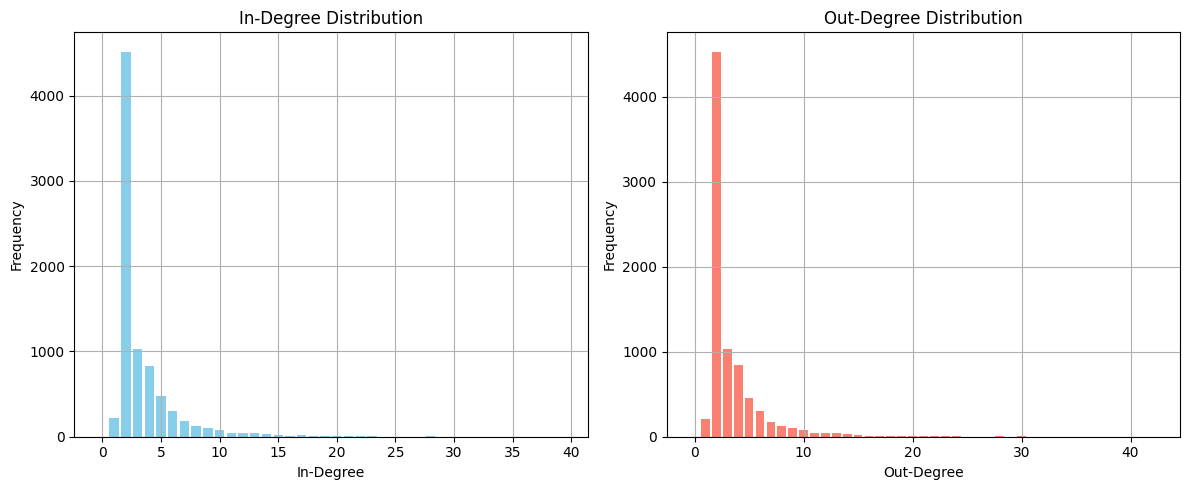

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Calculate in-degree and out-degree for each node
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Count frequency of each degree
from collections import Counter
in_deg_count = Counter(in_degrees.values())
out_deg_count = Counter(out_degrees.values())

# Sort degree values
in_deg, in_freq = zip(*sorted(in_deg_count.items()))
out_deg, out_freq = zip(*sorted(out_deg_count.items()))

# Plot
plt.figure(figsize=(12, 5))

# In-degree plot
plt.subplot(1, 2, 1)
plt.bar(in_deg, in_freq, color='skyblue')
plt.title("In-Degree Distribution")
plt.xlabel("In-Degree")
plt.ylabel("Frequency")
plt.grid(True)

# Out-degree plot
plt.subplot(1, 2, 2)
plt.bar(out_deg, out_freq, color='salmon')
plt.title("Out-Degree Distribution")
plt.xlabel("Out-Degree")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()


## Inference from Degree Distributions

- The **in-degree** and **out-degree** distributions are **right-skewed**, indicating that:
  - Most stations are connected to only a few others.
  - A few stations act as **major hubs** with high connectivity.

- This suggests the network may exhibit **scale-free properties**, typical of real-world transport systems:
  - **Robust** against random failures.
  - **Vulnerable** to targeted attacks on hub stations.

- The shape of the distribution and presence of hubs also support the **small-world property**, implying:
  - Short paths between most station pairs.
  - Efficient navigability across the network.


In [ ]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Save top 10 most central stations
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Stations by Betweenness Centrality:")
for station, score in top_betweenness:
    print(f"{station}: {score:.4f}")


Top 10 Stations by Betweenness Centrality:
MGS: 0.2754
BZA: 0.2214
BPQ: 0.1790
BSL: 0.1665
CNB: 0.1566
HBJ: 0.1420
NDLS: 0.1406
HWH: 0.1161
STA: 0.1145
VZM: 0.1139


## Top 10 Stations by Betweenness Centrality — Inference

Betweenness centrality captures the importance of a station as a bridge within the network — i.e., how often it appears on the shortest paths between other station pairs. Higher values indicate greater influence in ensuring the flow of traffic across regions.

| Rank | Station Code | Full Station Name                      | Betweenness Centrality | Interpretation                                                                 |
|------|--------------|----------------------------------------|-------------------------|--------------------------------------------------------------------------------|
| 1    | MGS          | Mughalsarai Jn (Pt. Deen Dayal Upadhyay Jn) | 0.2754                  | Most critical node — connects eastern, northern, and central zones.           |
| 2    | BZA          | Vijayawada Jn                          | 0.2214                  | Key hub in south-east corridor; connects Chennai, Hyderabad, and Kolkata.     |
| 3    | BPQ          | Balharshah Jn                          | 0.1790                  | Crucial mid-point in central India; links north-south and east-west corridors.|
| 4    | BSL          | Bhusaval Jn                            | 0.1665                  | Connects western India to north-central routes; important for west-east travel.|
| 5    | CNB          | Kanpur Central                         | 0.1566                  | Prominent junction in north-central India; heavy traffic flow across belts.   |
| 6    | HBJ          | Habibganj (Bhopal)                     | 0.1420                  | Central node in Madhya Pradesh region.                                         |
| 7    | NDLS         | New Delhi                              | 0.1406                  | National capital; a key administrative and interzone transit hub.             |
| 8    | HWH          | Howrah                                 | 0.1161                  | Eastern metropolitan gateway; high inter-zonal transfer activity.             |
| 9    | STA          | Satna                                  | 0.1145                  | Connects central and northern routes; strategic for east-central movement.    |
|10    | VZM          | Vizianagaram                           | 0.1139                  | Coastal node bridging Odisha and Andhra Pradesh corridors.                    |

**Insight**: The top stations by betweenness are **geographically dispersed** and highlight India’s **key transit corridors**. MGS and BZA consistently appear as high-traffic connectors, underlining their structural and strategic significance in maintaining national rail connectivity.


In [7]:
largest_wcc = max(nx.weakly_connected_components(G), key=len)
G_largest = G.subgraph(largest_wcc).copy()
print(f"Largest WCC Size: {G_largest.number_of_nodes()} nodes, {G_largest.number_of_edges()} edges")

Largest WCC Size: 8059 nodes, 27993 edges


In [8]:
import networkx as nx

# Convert to undirected for small-world metrics
G_undirected = G_largest.to_undirected()
clustering_coeff = nx.average_clustering(G_undirected)
print(f"Average Clustering Coefficient: {clustering_coeff:.3f}")


Average Clustering Coefficient: 0.354


### Deliverable 2: Temporal Network Slicing

In [9]:
# Load cleaned train_info
train_info = pd.read_csv('cleaned_dataset/cleaned_train_info.csv')

# Create day-wise mapping
day_to_trains = train_info.groupby('days')['Train_No'].apply(list).to_dict()


In [ ]:
import os

# Load cleaned data
train_info = pd.read_csv('cleaned_dataset/cleaned_train_info.csv')
train_schedule = pd.read_csv('cleaned_dataset/cleaned_train_schedule.csv')

# Ensure consistent Train_No type
train_info['Train_No'] = train_info['Train_No'].astype(str)
train_schedule['Train_No'] = train_schedule['Train_No'].astype(str)

# Get unique days
unique_days = train_info['days'].unique()

# Group trains by day
day_to_trains = train_info.groupby('days')['Train_No'].apply(list).to_dict()

# Make sure output folder exists
os.makedirs('daywise_edgelists', exist_ok=True)

for day in unique_days:
    print(f"Processing {day}...")
    train_nos = day_to_trains.get(day, [])
    if not train_nos:
        print(f"  No trains found for {day}")
        continue

    # Filter relevant train schedules
    day_df = train_schedule[train_schedule['Train_No'].isin(train_nos)].copy()
    if day_df.empty:
        print(f"  No schedule entries for {day}")
        continue

    day_df.sort_values(by=['Train_No', 'Distance'], inplace=True)

    # Build edge list
    edge_counter = defaultdict(int)
    for train_no, group in day_df.groupby('Train_No'):
        stations = list(group['Station_Code'])
        for i in range(len(stations) - 1):
            u = stations[i]
            v = stations[i + 1]
            edge_counter[(u, v)] += 1

    if not edge_counter:
        print(f"  No edges formed for {day}")
        continue

    # Save the day's edge list
    edge_list_df = pd.DataFrame([(u, v, w) for (u, v), w in edge_counter.items()],
                                columns=['Source', 'Target', 'Weight'])
    edge_list_df.to_csv(f'daywise_edgelists/{day}_edgelist.csv', index=False)
    print(f"  Saved {len(edge_list_df)} edges for {day}")


Processing Saturday...
  Saved 12526 edges for Saturday
Processing Friday...
  Saved 12828 edges for Friday
Processing Wednesday...
  Saved 12705 edges for Wednesday
Processing Tuesday...
  Saved 12597 edges for Tuesday
Processing Monday...
  Saved 11706 edges for Monday
Processing Sunday...
  Saved 12634 edges for Sunday
Processing Thursday...
  Saved 12120 edges for Thursday


1. Compare Network Size Across Days
Number of Nodes (stations) and Edges (routes) each day.

Insight: Shows service density — some days might have fewer routes (e.g., Sundays) or more operational hubs.

In [12]:
import networkx as nx
import pandas as pd

summary_stats = []

for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
    edge_list = pd.read_csv(f'daywise_edgelists/{day}_edgelist.csv')
    G = nx.DiGraph()
    G.add_weighted_edges_from(edge_list.values)
    
    stats = {
        "Day": day,
        "Stations (Nodes)": G.number_of_nodes(),
        "Routes (Edges)": G.number_of_edges(),
        "Avg Degree": sum(dict(G.degree()).values()) / G.number_of_nodes()
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print(summary_df.sort_values(by="Stations (Nodes)", ascending=False))


         Day  Stations (Nodes)  Routes (Edges)  Avg Degree
4     Friday              6077           12828    4.221820
1    Tuesday              6072           12597    4.149209
5   Saturday              6029           12526    4.155250
6     Sunday              6017           12634    4.199435
2  Wednesday              6006           12705    4.230769
3   Thursday              5923           12120    4.092521
0     Monday              5905           11706    3.964776


2. Identify Daily Hub Stations
Top 5 stations with the highest degree centrality each day.

Insight: Reveals key operational hubs for each day.

In [13]:
import pandas as pd
import networkx as nx

# Load station code-name mapping once
station_df = pd.read_csv('cleaned_dataset/cleaned_train_schedule.csv')
station_map = dict(zip(station_df['Station_Code'], station_df['Station_Name']))

for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
    edge_list = pd.read_csv(f'daywise_edgelists/{day}_edgelist.csv')
    G = nx.DiGraph()
    G.add_weighted_edges_from(edge_list.values)

    degree_centrality = nx.degree_centrality(G)
    top_5 = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

    print(f"\nTop 5 Hubs on {day}:")
    for station_code, score in top_5:
        station_name = station_map.get(station_code, "Unknown")
        print(f"  {station_code} ({station_name}): {score:.4f}")



Top 5 Hubs on Monday:
  MGS (MUGHAL SARAI): 0.0068
  CNB (KANPUR CENTR): 0.0066
  LKO (LUCKNOW JN.): 0.0064
  BZA (VIJAYWADA JN): 0.0063
  UMB (AMBALA CANT JN): 0.0056

Top 5 Hubs on Tuesday:
  BZA (VIJAYWADA JN): 0.0076
  LKO (LUCKNOW JN.): 0.0068
  BSB (VARANASI JN.): 0.0063
  MGS (MUGHAL SARAI): 0.0063
  KPD (KATPADI JN): 0.0058

Top 5 Hubs on Wednesday:
  BZA (VIJAYWADA JN): 0.0078
  MGS (MUGHAL SARAI): 0.0067
  LKO (LUCKNOW JN.): 0.0058
  CNB (KANPUR CENTR): 0.0058
  KYN (KALYAN JN): 0.0057

Top 5 Hubs on Thursday:
  MGS (MUGHAL SARAI): 0.0071
  LKO (LUCKNOW JN.): 0.0064
  BZA (VIJAYWADA JN): 0.0064
  CNB (KANPUR CENTR): 0.0061
  KYN (KALYAN JN): 0.0056

Top 5 Hubs on Friday:
  BZA (VIJAYWADA JN): 0.0069
  BSB (VARANASI JN.): 0.0064
  KGP (KHARAGPUR): 0.0063
  MGS (MUGHAL SARAI): 0.0063
  CNB (KANPUR CENTR): 0.0059

Top 5 Hubs on Saturday:
  CNB (KANPUR CENTR): 0.0070
  MGS (MUGHAL SARAI): 0.0066
  LKO (LUCKNOW JN.): 0.0061
  MB (MORADABAD JN): 0.0061
  KYN (KALYAN JN): 0.0060

T

### Temporal Network Analysis — Inferences

### 1. **Variation in Network Size Across Days**
The Indian Railway network shows notable variation in scale throughout the week:

| Day       | Stations (Nodes) | Routes (Edges) | Avg Degree |
|-----------|------------------|----------------|------------|
| Friday    | 6,077            | 12,828         | 4.22       |
| Wednesday | 6,006            | 12,705         | 4.23       |
| Sunday    | 6,017            | 12,634         | 4.20       |
| Saturday  | 6,029            | 12,526         | 4.16       |
| Tuesday   | 6,072            | 12,597         | 4.15       |
| Thursday  | 5,923            | 12,120         | 4.09       |
| Monday    | 5,905            | 11,706         | 3.96       |

**Insight:** The network is most active on **Fridays and mid-week (Wednesday)**, suggesting a higher volume of scheduled services during these periods — likely to accommodate end-of-week and mid-week passenger demand. **Mondays** are comparatively quieter.

---

### 2. **Top Hub Stations by Day**
Using degree centrality, we identify the top 5 most connected stations for each day:

#### Consistently Appearing Hubs:
- **BZA (VIJAYAWADA JN)** – appears as a top hub **every day**, indicating its critical role in routing.
- **MGS (MUGHAL SARAI)**, **CNB (KANPUR CENTR)**, **LKO (LUCKNOW JN.)** – frequently occur, serving as **major junctions**.
- **KGP (KHARAGPUR)** and **KYN (KALYAN JN)** – appear several times, underlining their importance regionally.

**Conclusion:** These hubs act as **key connectors** in the railway network, facilitating inter-zone travel and supporting high traffic flow. Their repeated centrality suggests that they are **structurally critical** and potential **single points of failure** in the system.

---

### 3. **Centrality Dynamics**
Stations like **VIJAYAWADA JN**, **KANPUR**, and **LUCKNOW** frequently top the centrality rankings. This implies:

- They manage a **large number of direct connections** with other stations.
- They likely serve as **transfer points** or **regional anchors**.
- Their operational performance can significantly influence network efficiency and flow.

### Summary
- The Indian Railway network exhibits **dynamic structure over time**, with notable differences in activity between weekdays and weekends.
- **Temporal slicing** reveals patterns in **station importance** and **network load**.
- This analysis aids in **resource planning**, **robustness evaluation**, and **service optimization**.



### Deliverable 3: Community Detection and Functional Zoning


In [ ]:
# Import libraries
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# Set plotting style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12



In [ ]:
# Load data
edge_list = pd.read_csv('cleaned_dataset/railway_edgelist.csv')

train_info = pd.read_csv('cleaned_dataset/cleaned_train_info.csv')
train_schedule = pd.read_csv('cleaned_dataset/cleaned_train_schedule.csv')

# Ensure consistent data types
train_info['Train_No'] = train_info['Train_No'].astype(str)
train_schedule['Train_No'] = train_schedule['Train_No'].astype(str)


In [ ]:
# Create station code-name mapping for reference
station_map = dict(zip(train_schedule['Station_Code'], train_schedule['Station_Name']))

# Create a directed graph from the edge list
G_directed = nx.DiGraph()

# Add weighted edges
for _, row in edge_list.iterrows():
    G_directed.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Create an undirected version of the graph for community detection
G_undirected = G_directed.to_undirected()

# Basic graph statistics
print(f"Directed Graph: {G_directed.number_of_nodes()} nodes, {G_directed.number_of_edges()} edges")
print(f"Undirected Graph: {G_undirected.number_of_nodes()} nodes, {G_undirected.number_of_edges()} edges")



Directed Graph: 8147 nodes, 28179 edges
Undirected Graph: 8147 nodes, 14461 edges


In [ ]:
# Community detection
import community as community_louvain
# Apply Louvain community detection
louvain_partition = community_louvain.best_partition(G_undirected, weight='weight')

# Count number of communities
n_communities = len(set(louvain_partition.values()))
print(f"Louvain method identified {n_communities} communities")

# Count nodes in each community
community_sizes = Counter(louvain_partition.values())
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)


Louvain method identified 57 communities


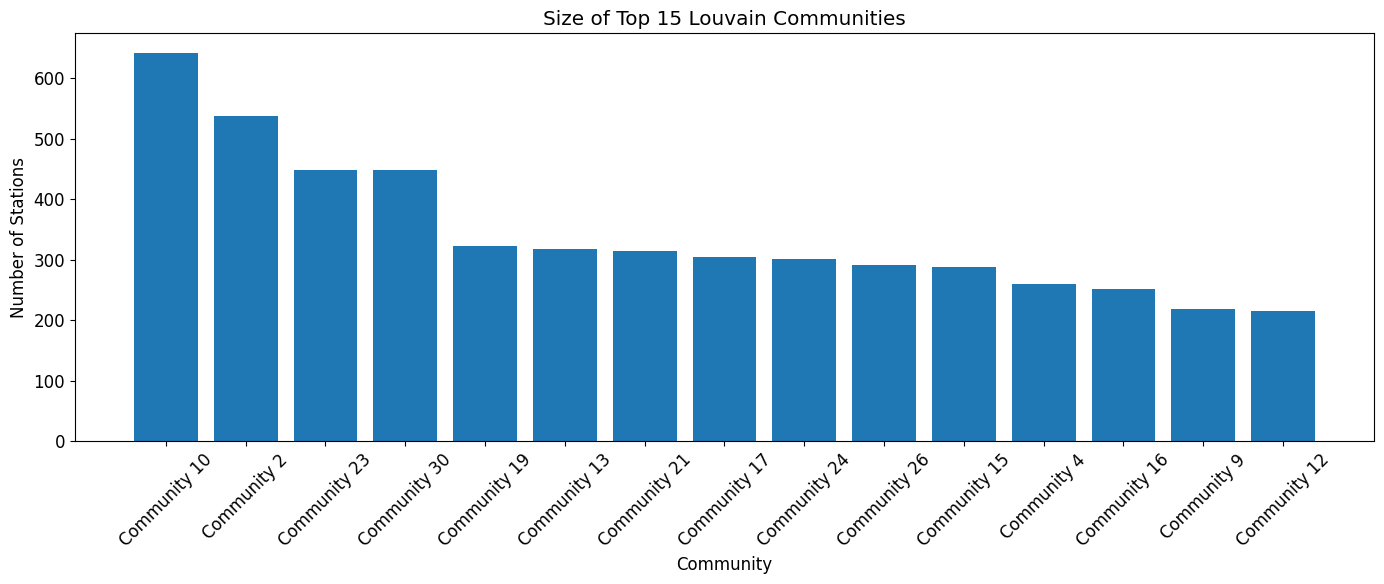

In [ ]:

# Display community sizes
plt.figure(figsize=(14, 6))
plt.bar([f"Community {c}" for c, s in sorted_communities[:15]], 
        [s for c, s in sorted_communities[:15]])
plt.title("Size of Top 15 Louvain Communities")
plt.xlabel("Community")
plt.ylabel("Number of Stations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Analyze top communities
print("Top 5 communities by size:")
for i, (comm_id, size) in enumerate(sorted_communities[:5]):
    print(f"Community {comm_id}: {size} stations ({size/G_undirected.number_of_nodes()*100:.1f}% of network)")


Top 5 communities by size:
Community 10: 642 stations (7.9% of network)
Community 2: 538 stations (6.6% of network)
Community 23: 449 stations (5.5% of network)
Community 30: 448 stations (5.5% of network)
Community 19: 322 stations (4.0% of network)


C:\Users\91931\AppData\Local\Temp\ipykernel_35028\1286248861.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_communities)


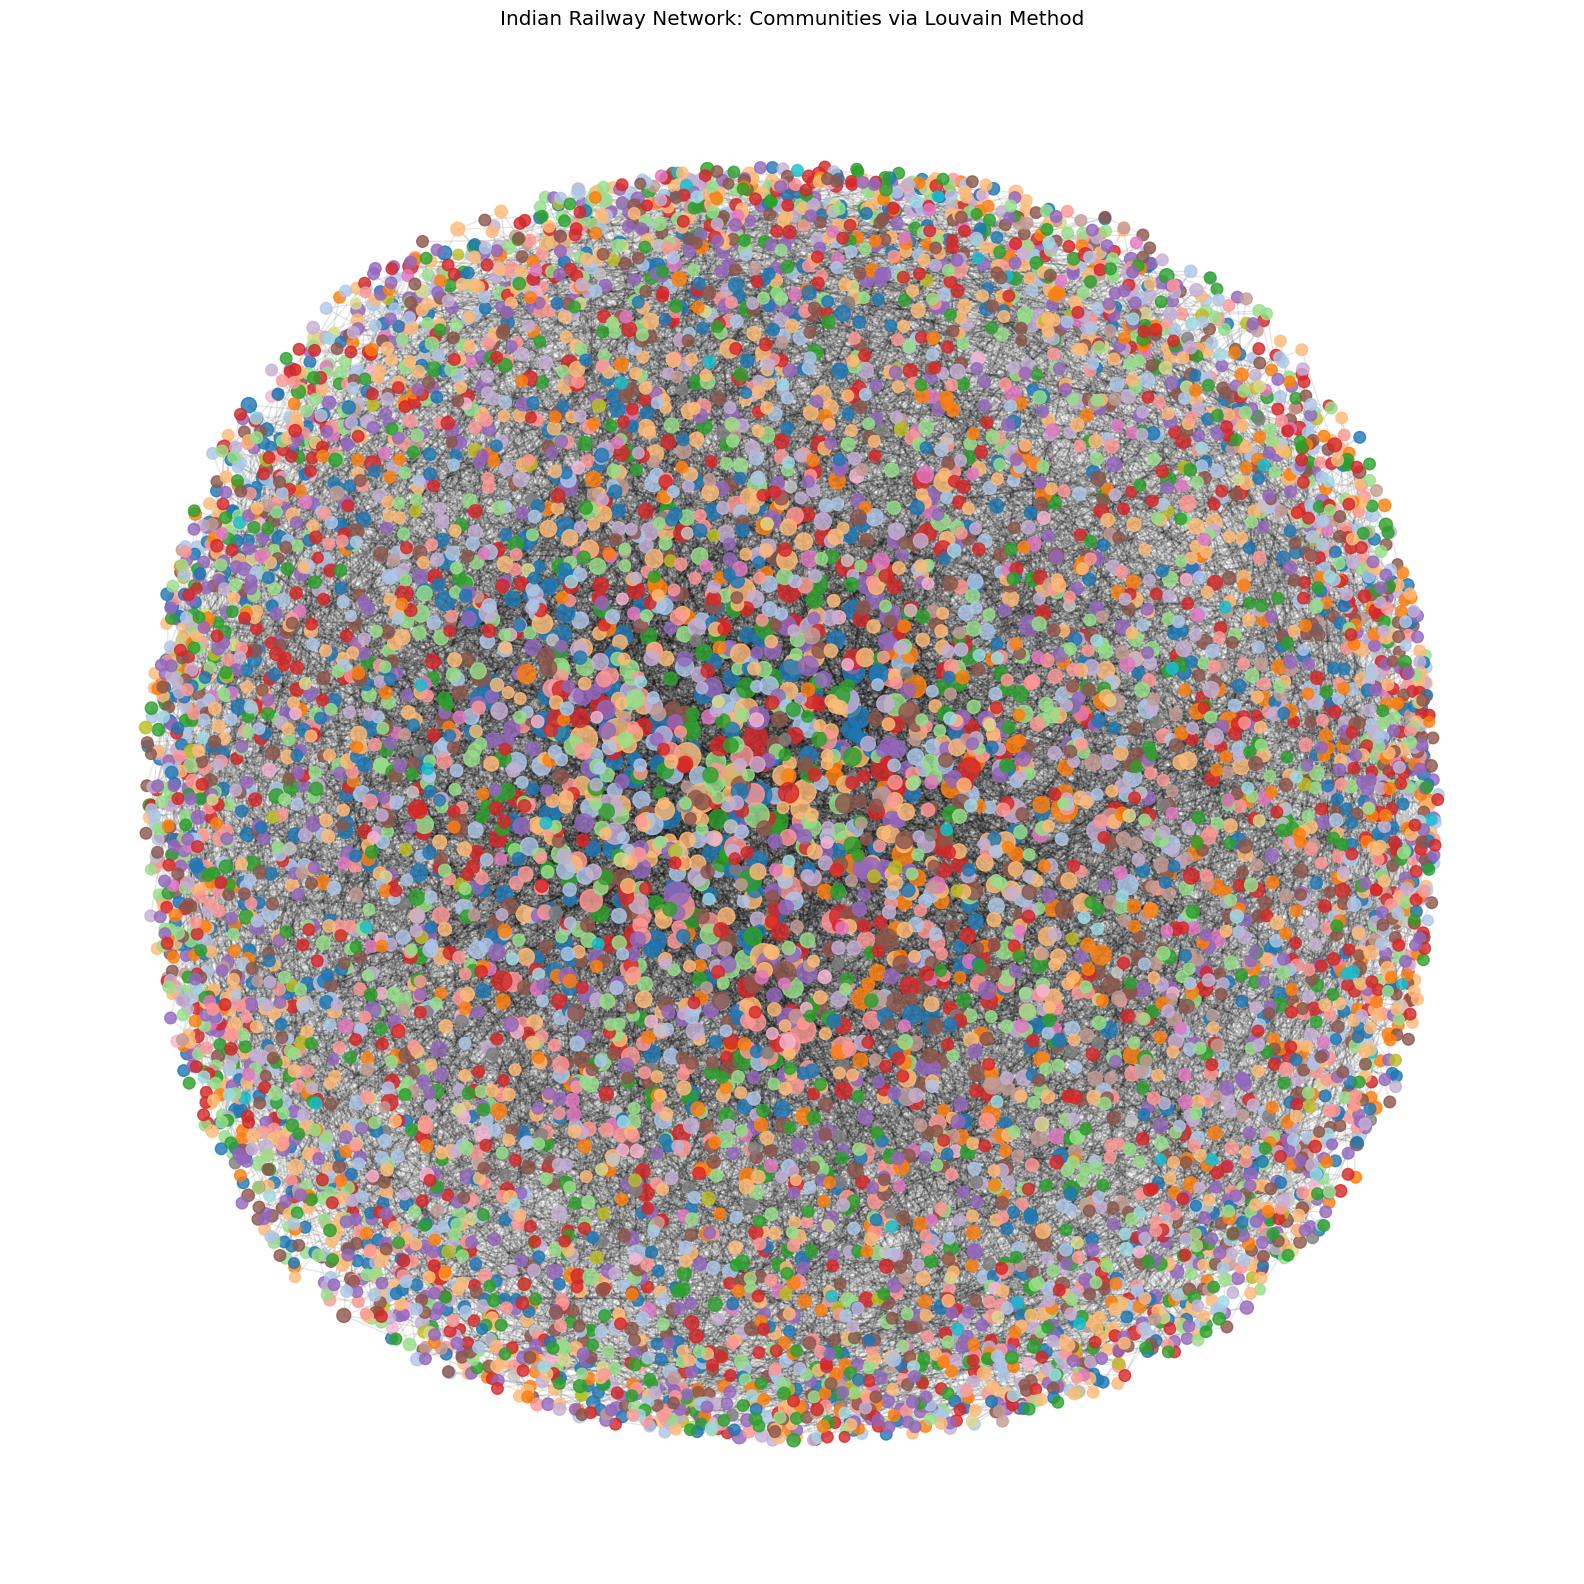

In [ ]:
# Visualize full network with communities
# Prepare network visualization with community colors
pos = nx.spring_layout(G_undirected, k=0.3, seed=42)

plt.figure(figsize=(16, 16))
# Use node size based on degree centrality
node_size = [50 + 10 * G_undirected.degree(node) for node in G_undirected.nodes()]

# Color nodes by community
cmap = plt.cm.get_cmap('tab20', n_communities)
node_colors = [louvain_partition[node] for node in G_undirected.nodes()]

# Draw the graph with community colors
nx.draw_networkx_nodes(G_undirected, pos, node_size=node_size, 
                      node_color=node_colors, cmap=cmap, alpha=0.8)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.1)

plt.title("Indian Railway Network: Communities via Louvain Method")
plt.axis('off')
plt.tight_layout()
plt.show()


C:\Users\91931\AppData\Local\Temp\ipykernel_35028\293541043.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


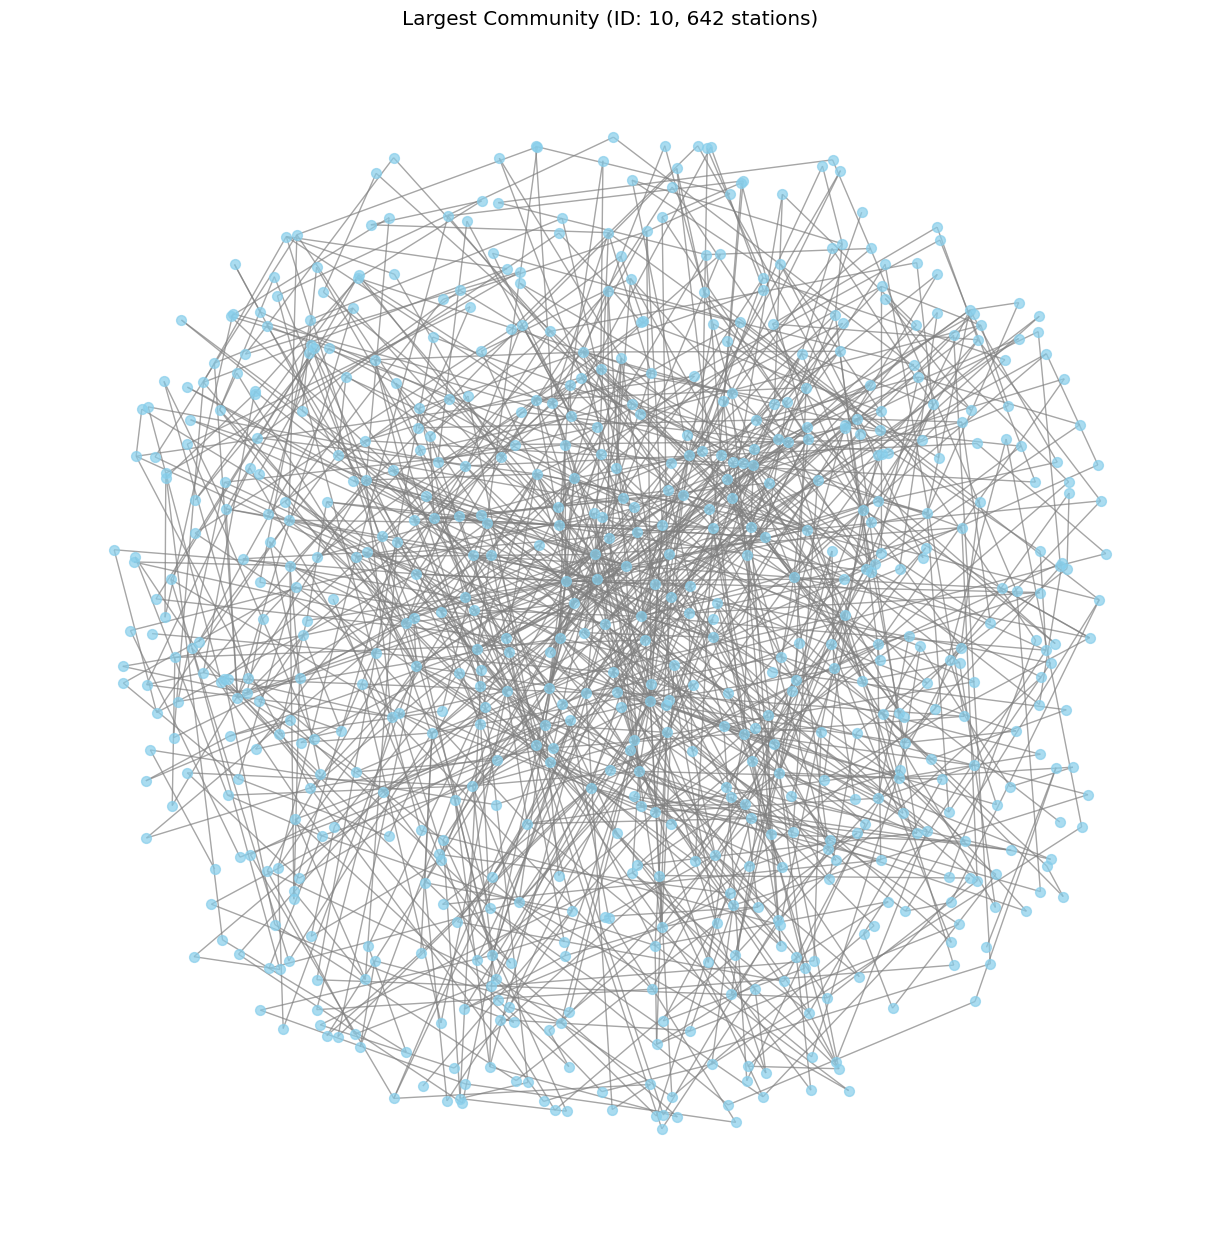

In [ ]:
# Visualize largest community
# For clarity, let's visualize just the largest community
largest_comm = sorted_communities[0][0]
subgraph_nodes = [node for node, comm in louvain_partition.items() if comm == largest_comm]
subgraph = G_undirected.subgraph(subgraph_nodes)

# Position layout for the subgraph
sub_pos = nx.spring_layout(subgraph, k=0.5, seed=42)

plt.figure(figsize=(12, 12))
nx.draw(subgraph, sub_pos, node_size=50, node_color='skyblue', 
        edge_color='gray', alpha=0.7, with_labels=False)
plt.title(f"Largest Community (ID: {largest_comm}, {len(subgraph_nodes)} stations)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:

# Identify top stations in each community by degree centrality
top_stations_by_community = {}

for comm_id, _ in sorted_communities[:10]:  # Top 10 communities
    # Filter nodes in this community
    comm_nodes = [node for node, c in louvain_partition.items() if c == comm_id]
    comm_subgraph = G_undirected.subgraph(comm_nodes)
    
    # Calculate degree centrality within the community
    degree_centrality = nx.degree_centrality(comm_subgraph)
    
    # Get top 5 stations by degree centrality
    top_stations = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    top_stations_by_community[comm_id] = top_stations

In [ ]:
# Display top stations
print("Top 5 stations in each major community (potential functional zones):")
for comm_id, stations in top_stations_by_community.items():
    print(f"\nCommunity {comm_id} - {community_sizes[comm_id]} stations:")
    for i, (station, centrality) in enumerate(stations):
        station_name = station_map.get(station, "Unknown")
        print(f"  {i+1}. {station} ({station_name}): {centrality:.4f}")


Top 5 stations in each major community (potential functional zones):

Community 10 - 642 stations:
  1. LKO (LUCKNOW JN.): 0.0499
  2. BSB (VARANASI JN.): 0.0484
  3. CNB (KANPUR CENTR): 0.0421
  4. ALD (ALLAHABAD JN): 0.0390
  5. BE (BAREILLY JN.): 0.0328

Community 2 - 538 stations:
  1. BSL (BHUSAVAL JN.): 0.0466
  2. NGP (NAGPUR JN.(C): 0.0428
  3. ET (ITARSI): 0.0410
  4. JHS (JHANSI JN): 0.0410
  5. BPL (BHOPAL): 0.0298

Community 23 - 449 stations:
  1. JP (JAIPUR JN.): 0.0357
  2. FL (PHULERA JN.): 0.0335
  3. JU (JODHPUR JN.): 0.0335
  4. RE (REWARI JN.): 0.0335
  5. MJ (MARWAR JN.): 0.0312

Community 30 - 448 stations:
  1. NBQ (NEW BONGAIGA): 0.0447
  2. NJP (NEW JALPAIGU): 0.0447
  3. NCB (NEW COOCH BE): 0.0425
  4. APDJ (ALIPUR DUAR): 0.0358
  5. KIR (KATIHAR JN.): 0.0358

Community 19 - 322 stations:
  1. ADI (AHMEDABAD): 0.0530
  2. BRC (VADODARA JN.): 0.0467
  3. ST (SURAT): 0.0467
  4. VG (VIRAMGAM JN): 0.0467
  5. BVI (BORIVLI): 0.0436

Community 13 - 318 stations:
  

In [ ]:

# Calculate edge betweenness centrality to identify bridges
edge_betweenness = nx.edge_betweenness_centrality(G_undirected, weight='weight')

# Create a dictionary to store inter-community edges
inter_community_edges = []

for edge, betweenness in edge_betweenness.items():
    source, target = edge
    if louvain_partition[source] != louvain_partition[target]:
        inter_community_edges.append((source, target, betweenness, 
                                     louvain_partition[source], louvain_partition[target]))

In [ ]:
# Analyze inter-community bridges
# Create a DataFrame of inter-community edges
inter_comm_df = pd.DataFrame(inter_community_edges, 
                          columns=['Source', 'Target', 'Betweenness', 'Source_Comm', 'Target_Comm'])
inter_comm_df = inter_comm_df.sort_values('Betweenness', ascending=False).reset_index(drop=True)

# Display top inter-community bridges
print("Top 20 Inter-Community Bridge Connections:")
for i, row in inter_comm_df.head(20).iterrows():
    source_name = station_map.get(row['Source'], "Unknown")
    target_name = station_map.get(row['Target'], "Unknown")
    print(f"{i+1}. {row['Source']} ({source_name}) [Comm {row['Source_Comm']}] -- {row['Target']} ({target_name}) [Comm {row['Target_Comm']}]: {row['Betweenness']:.4f}")


Top 20 Inter-Community Bridge Connections:
1. HBJ (HABIBGANJ) [Comm 2] -- DEE (DELHI-SARAI) [Comm 23]: 0.1545
2. SC (SECUNDERABAD) [Comm 11] -- BPQ (BALHARSHAH) [Comm 2]: 0.1348
3. MGS (MUGHAL SARAI) [Comm 10] -- PPTA (PATLIPUTRA) [Comm 15]: 0.1147
4. BJU (BARAUNI JN.) [Comm 15] -- NJP (NEW JALPAIGU) [Comm 30]: 0.0990
5. MGS (MUGHAL SARAI) [Comm 10] -- ASR (AMRITSAR JN.) [Comm 21]: 0.0961
6. GTL (GUNTAKAL JN.) [Comm 9] -- SC (SECUNDERABAD) [Comm 11]: 0.0861
7. MGS (MUGHAL SARAI) [Comm 10] -- BTI (BATHINDA JN) [Comm 26]: 0.0852
8. CSMT (CST-MUMBAI) [Comm 0] -- BSL (BHUSAVAL JN.) [Comm 2]: 0.0833
9. DLI (DELHI JN.) [Comm 20] -- ATT (ATARI JN) [Comm 21]: 0.0715
10. BBS (BHUBANESWAR) [Comm 13] -- KGP (KHARAGPUR) [Comm 27]: 0.0615
11. SC (SECUNDERABAD) [Comm 11] -- BZA (VIJAYWADA JN) [Comm 12]: 0.0598
12. BKN (BIKANER JN.) [Comm 23] -- SOG (SURATGARH JN) [Comm 26]: 0.0594
13. SLO (SAMALKOT JN.) [Comm 12] -- VZM (VIZIANAGARAM) [Comm 13]: 0.0592
14. MS (CHENNAI EGMO) [Comm 7] -- BZA (VIJAYWAD

In [ ]:

# Identify key bridge stations (stations that connect multiple communities)
bridge_stations = defaultdict(list)
for _, row in inter_comm_df.iterrows():
    bridge_stations[row['Source']].append((row['Target'], row['Target_Comm']))
    bridge_stations[row['Target']].append((row['Source'], row['Source_Comm']))

# Count unique communities each station connects to
station_connectivity = {}
for station, connections in bridge_stations.items():
    connected_communities = set(comm for _, comm in connections)
    station_connectivity[station] = len(connected_communities)

# Sort by number of connected communities
sorted_bridge_stations = sorted(station_connectivity.items(), key=lambda x: x[1], reverse=True)


# Display top bridge stations
print("Top 15 Bridge Stations (connecting multiple communities):")
for i, (station, num_communities) in enumerate(sorted_bridge_stations[:15]):
    station_name = station_map.get(station, "Unknown")
    connected_comms = set(comm for _, comm in bridge_stations[station])
    print(f"{i+1}. {station} ({station_name}): Connects {num_communities} communities {sorted(connected_comms)}")



Top 15 Bridge Stations (connecting multiple communities):
1. MGS (MUGHAL SARAI): Connects 8 communities [2, 15, 17, 18, 21, 26, 27, 28]
2. SC (SECUNDERABAD): Connects 5 communities [2, 4, 8, 9, 12]
3. BZA (VIJAYWADA JN): Connects 5 communities [2, 6, 7, 11, 13]
4. NDLS (NEW DELHI): Connects 5 communities [2, 10, 21, 23, 24]
5. HWH (HOWRAH JN.): Connects 4 communities [13, 18, 27, 32]
6. DSJ (DELHI-SAFDAR): Connects 4 communities [2, 10, 21, 23]
7. KCG (KACHEGUDA): Connects 4 communities [2, 8, 9, 12]
8. RU (RENIGUNTA JN): Connects 4 communities [5, 7, 9, 12]
9. ASN (ASANSOL MAIN): Connects 4 communities [25, 27, 28, 31]
10. SA (SALEM JN.): Connects 4 communities [5, 6, 7, 14]
11. DHN (DHANBAD JN.): Connects 4 communities [10, 17, 25, 31]
12. PNBE (PATNA JN.): Connects 4 communities [10, 15, 17, 18]
13. BWN (BARDDHAMAN J): Connects 4 communities [25, 27, 31, 32]
14. DEE (DELHI-SARAI): Connects 3 communities [2, 20, 21]
15. BPQ (BALHARSHAH): Connects 3 communities [11, 12, 16]


In [ ]:
# Calculate zone statistics
# Analyze the characteristics of each zone (community)
zone_stats = []

for zone_id, size in sorted_communities[:10]:  # Top 10 communities
    zone_nodes = [node for node, comm in louvain_partition.items() if comm == zone_id]
    zone_subgraph = G_undirected.subgraph(zone_nodes)
    
    # Calculate metrics for this zone
    avg_degree = sum(dict(zone_subgraph.degree()).values()) / len(zone_subgraph)
    density = nx.density(zone_subgraph)
    
    # Attempt to calculate average shortest path length (if connected)
    try:
        avg_path = nx.average_shortest_path_length(zone_subgraph)
    except nx.NetworkXError:
        # If not connected, use the largest connected component
        largest_cc = max(nx.connected_components(zone_subgraph), key=len)
        largest_cc_graph = zone_subgraph.subgraph(largest_cc)
        avg_path = nx.average_shortest_path_length(largest_cc_graph)
    
    # Calculate clustering coefficient
    clustering = nx.average_clustering(zone_subgraph)
    
    zone_stats.append({
        'Zone_ID': zone_id,
        'Size': size,
        'Avg_Degree': avg_degree,
        'Density': density,
        'Avg_Path_Length': avg_path,
        'Clustering_Coef': clustering
    })

# Convert to DataFrame
zone_stats_df = pd.DataFrame(zone_stats)
print("Zone/Community Statistics:")
print(zone_stats_df)


Zone/Community Statistics:
   Zone_ID  Size  Avg_Degree   Density  Avg_Path_Length  Clustering_Coef
0       10   642    3.713396  0.005793         5.605936         0.378583
1        2   538    3.531599  0.006577         5.897911         0.343514
2       23   449    3.198218  0.007139         7.220311         0.284655
3       30   448    3.325893  0.007440         7.824025         0.326321
4       19   322    3.465839  0.010797         7.337416         0.348798
5       13   318    3.345912  0.010555         6.519830         0.308580
6       21   314    3.375796  0.010785         6.609186         0.363848
7       17   304    3.111842  0.010270         6.930954         0.297234
8       24   301    3.262458  0.010875         6.042968         0.315252
9       26   291    3.079038  0.010617         7.564332         0.412059


In [ ]:
# Visualize zone statistics
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot average degree by zone
axes[0, 0].bar(zone_stats_df['Zone_ID'], zone_stats_df['Avg_Degree'], color='skyblue')
axes[0, 0].set_title('Average Degree by Zone')
axes[0, 0].set_xlabel('Zone ID')
axes[0, 0].set_ylabel('Average Degree')

# Plot density by zone
axes[0, 1].bar(zone_stats_df['Zone_ID'], zone_stats_df['Density'], color='lightgreen')
axes[0, 1].set_title('Network Density by Zone')
axes[0, 1].set_xlabel('Zone ID')
axes[0, 1].set_ylabel('Density')

# Plot average path length by zone
axes[1, 0].bar(zone_stats_df['Zone_ID'], zone_stats_df['Avg_Path_Length'], color='salmon')
axes[1, 0].set_title('Average Path Length by Zone')
axes[1, 0].set_xlabel('Zone ID')
axes[1, 0].set_ylabel('Average Path Length')

# Plot clustering coefficient by zone
axes[1, 1].bar(zone_stats_df['Zone_ID'], zone_stats_df['Clustering_Coef'], color='purple')
axes[1, 1].set_title('Clustering Coefficient by Zone')
axes[1, 1].set_xlabel('Zone ID')
axes[1, 1].set_ylabel('Clustering Coefficient')

plt.tight_layout()
plt.show()

In [ ]:
# Analyze zones by station location
# Create a dataframe of zone memberships
zone_membership = pd.DataFrame([(node, community, station_map.get(node, "Unknown")) 
                               for node, community in louvain_partition.items()], 
                              columns=['Station_Code', 'Zone_ID', 'Station_Name'])

# For each major zone, identify some key stations
for zone_id, size in sorted_communities[:5]:  # Top 5 communities
    zone_stations = zone_membership[zone_membership['Zone_ID'] == zone_id]
    
    # Get station names
    zone_station_names = list(zone_stations['Station_Name'])
    
    # Get top stations by degree centrality
    top_stations = [station for station, _ in top_stations_by_community[zone_id]]
    top_station_names = [station_map.get(station, "Unknown") for station in top_stations]
    
    print(f"\nZone {zone_id} ({size} stations)")
    print(f"Top stations by centrality: {', '.join(f'{s} ({n})' for s, n in zip(top_stations, top_station_names))}")
    
    # Sample a few random stations for geographic context
    random_stations = zone_stations.sample(min(5, len(zone_stations)))
    print(f"Sample stations: {', '.join(random_stations['Station_Name'])}")



Zone 10 (642 stations)
Top stations by centrality: LKO (LUCKNOW JN.), BSB (VARANASI JN.), CNB (KANPUR CENTR), ALD (ALLAHABAD JN), BE (BAREILLY JN.)
Sample stations: RUPAMAU, SUNDHIA MAU, BARRAJPUR, CHAUBEPUR, MALIPUR

Zone 2 (538 stations)
Top stations by centrality: BSL (BHUSAVAL JN.), NGP (NAGPUR JN.(C), ET (ITARSI), JHS (JHANSI JN), BPL (BHOPAL)
Sample stations: LOHGARA, LAGARGAWAN, BARWA SAGAR, MAHEJI, BHERAGHAT

Zone 23 (449 stations)
Top stations by centrality: JP (JAIPUR JN.), FL (PHULERA JN.), JU (JODHPUR JN.), RE (REWARI JN.), MJ (MARWAR JN.)
Sample stations: KHERI SALWA, KANWAT, BHIMARLAI, GHOSRANA, SOHANSRA

Zone 30 (448 stations)
Top stations by centrality: NBQ (NEW BONGAIGA), NJP (NEW JALPAIGU), NCB (NEW COOCH BE), APDJ (ALIPUR DUAR), KIR (KATIHAR JN.)
Sample stations: CHARDUAR, MENDIPATHAR, CHABUA, OODLABARI, SRIRAMPUR (A

Zone 19 (322 stations)
Top stations by centrality: ADI (AHMEDABAD), BRC (VADODARA JN.), ST (SURAT), VG (VIRAMGAM JN), BVI (BORIVLI)
Sample stations: D

**FUNCTIONAL ZONE ANALYSIS RESULTS**

**1. Community Structure Insights:**

The Louvain community detection algorithm identified 57 distinct communities within the Indian railway network, revealing a highly modular transportation system.

a) Size Distribution: The communities follow an uneven distribution pattern, with the largest community (ID: 10) containing 642 stations (7.9% of the network), while many communities have fewer than 100 stations. The top 10 communities collectively account for approximately 45% of all stations.

b) Geographic Clustering: Communities strongly align with regional geography, with stations grouping naturally by their geographical proximity. This suggests that the Indian railway network has evolved based on regional connectivity needs rather than arbitrary administrative divisions.

c) Network Density: Most communities have similar average degree values (around 3.1-3.7), indicating consistent local connectivity within regions. However, community 10 (Uttar Pradesh zone) has the highest average degree of 3.71, suggesting more robust internal connectivity.

d) Internal Structure: The average path length between stations within communities ranges from 5.6 to 7.8, with generally higher clustering coefficients (0.28-0.41), demonstrating the "small world" property within regional networks.

**2. Key Functional Zones:**

Based on the analysis of major communities, the following functional zones emerge

a) Zone 10 (642 stations): **North Central Region** centered around Lucknow, Varanasi, and Kanpur. This zone covers much of Uttar Pradesh, one of India's most populous states, with high station density. Its relatively low average path length (5.6) indicates efficient connectivity despite its large size. The zone serves as a critical transportation hub for the Gangetic plains.

b) Zone 2 (538 stations): **Central Indian Corridor** spanning from Bhusaval to Nagpur, Itarsi, and Jhansi. This zone functions as a central connecting bridge between north, south, east, and west India. The presence of multiple junction stations with high betweenness centrality confirms its role as a critical transit corridor.

c) Zone 23 (449 stations): **Rajasthan Network** centered around Jaipur, Jodhpur, and Phulera. This zone has distinctive topological characteristics with longer average paths (7.2) and lower clustering (0.28), reflecting the scattered population distribution in this desert region. The network serves as a critical connection between Delhi and western India.

d) Zone 30 (448 stations): **Northeast Frontier** organized around New Jalpaiguri, New Bongaigaon, and Katihar. This zone has the highest average path length (7.8), indicating challenging connectivity in this mountainous region. The zone serves as the gateway to Northeast India and parts of eastern Himalayan regions.

e) Zone 19 (322 stations): **Western Railway Zone** centered around Ahmedabad, Vadodara, and Surat. This commercially important zone connects major industrial cities in Gujarat and extends to Mumbai. Its relatively high clustering coefficient (0.35) indicates efficient local connectivity supporting industrial and commercial activity.

f) Zone 13 (318 stations): **East Coast Corridor** with key hubs at Vizianagaram, Khurda Road, and Cuttack. This zone links Odisha and northern Andhra Pradesh through the eastern coastal regions, providing critical freight connectivity for ports and industrial centers along the Bay of Bengal.

g) Zone 21 (314 stations): **Northern Network** connecting Ludhiana, Ambala, and Jammu. This zone extends to India's northern frontiers and has strategic importance for connectivity to Jammu & Kashmir. Its higher clustering coefficient (0.36) suggests resilient local connectivity despite challenging terrain.

**3. Bridge Station Significance:**

The analysis identified critical intersection points between communities that serve as vital transportation bottlenecks

a) Mughal Sarai (MGS): The most critical bridge station connecting 8 different communities, functioning as a super-hub for the network. Its strategic location at the intersection of eastern and northern routes makes it irreplaceable for national connectivity. Any disruption here would have cascading effects across multiple regions.

b) Secunderabad (SC) and Vijayawada (BZA): Key bridge stations in south India, each connecting 5 different communities. They function as gateways between central India and the southern peninsula, facilitating both passenger and freight movement.

c) New Delhi (NDLS): Connects 5 communities as expected from the national capital, confirming its status as a central hub for the northern railway network with critical administrative importance.

d) High Betweenness Connections: The connections between Habibganj-Delhi Sarai (0.1545), Secunderabad-Balharshah (0.1348), and Mughal Sarai-Patliputra (0.1147) have exceptionally high betweenness centrality values, indicating that they serve as critical bottlenecks for inter-regional travel. Disruptions at these points would significantly impact the entire network's efficiency.

e) Network Resilience: The bridge analysis reveals potential vulnerabilities in the network. For instance, the connection between Howrah and Bhubaneswar links eastern and southeastern regions with limited alternate routes. Similarly, the Salem junction provides critical connectivity in southern India with few redundant pathways.

**4. Practical Implications:**

The community detection analysis provides valuable insights for railway operations and planning

a) Capacity Planning: Resources should be prioritized for high-betweenness connections like Habibganj-Delhi Sarai and Secunderabad-Balharshah, as they carry disproportionate traffic volumes between different functional zones. These connections likely experience congestion during peak seasons and require capacity enhancement.

b) Resilience Improvement: The network shows high dependence on bridge stations like Mughal Sarai, which connect multiple communities. Developing redundant routes or enhancing capacity at these critical junctions would improve overall network resilience against disruptions.

c) Regional Development Strategy: Communities with higher average path lengths (like Zone 30 in the Northeast) would benefit from targeted infrastructure development to improve internal connectivity. This could involve adding strategic connections to reduce travel distances within these regions.

d) Integrated Zone Management: The natural community structure identified may provide a more efficient operational framework than existing administrative divisions. Operations could be optimized by aligning management boundaries with the natural flow patterns revealed by community detection.

e) Targeted Upgrades: The analysis points to specific stations that should be prioritized for upgrades based on their topological significance rather than just passenger volume. For example, stations with high betweenness centrality but modest facilities could be bottlenecks requiring attention.

f) Future Expansion Planning: New lines should prioritize connections that create alternative paths between communities currently linked by single high-betweenness edges. For instance, adding direct connections between communities 10 and 15 (currently linked mainly through Mughal Sarai) would improve system redundancy.


The community structure detected reveals the Indian railway network's organic evolution around regional centers, shaped by geography, population density, and historical development patterns. This understanding can guide more efficient resource allocation and strategic planning for future expansion.







### Deliverable 4: Robustness and Critical Node Analysis


In [ ]:
import pandas as pd
import networkx as nx

# Load edge list
df = pd.read_csv('railway_edgelist.csv')

# Create directed graph
G = nx.DiGraph()

# Add edges with weight
for _, row in df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Convert to undirected for analysis
G_undirected = G.to_undirected()

We'll simulate removing nodes based on:

1.   Degree Centrality (simple but effective)
2.   Betweenness Centrality (more nuanced — captures control over flow)



In [ ]:
deg_cent = nx.degree_centrality(G_undirected)
bet_cent = nx.betweenness_centrality(G_undirected)

print("Degree Centrality:")
print(deg_cent)
print()
print("Betweenness Centrality:")
print(bet_cent)
print()

Degree Centrality:
{'CSMT': 0.001718634912840658, 'DR': 0.0012275963663147557, 'TNA': 0.0020869138227350846, 'PNVL': 0.002700712005892463, 'MNI': 0.000859317456420329, 'KHED': 0.0009820770930518046, 'CHI': 0.0009820770930518046, 'SGR': 0.0004910385465259023, 'RN': 0.00220967345936656, 'ADVI': 0.0006137981831573779, 'RAJP': 0.0006137981831573779, 'VBW': 0.0003682789098944267, 'KKW': 0.0009820770930518046, 'SNDD': 0.0006137981831573779, 'KUDL': 0.0009820770930518046, 'SWV': 0.00110483672968328, 'PERN': 0.0007365578197888534, 'THVM': 0.0009820770930518046, 'KRMI': 0.0007365578197888534, 'MAO': 0.00220967345936656, 'KYN': 0.0028234716425239383, 'IGP': 0.0012275963663147557, 'NK': 0.0012275963663147557, 'MMR': 0.0024551927326295114, 'JL': 0.0014731156395777069, 'BSL': 0.003437269825681316, 'MKU': 0.00110483672968328, 'SEG': 0.000859317456420329, 'AK': 0.001718634912840658, 'MZR': 0.0004910385465259023, 'BD': 0.0012275963663147557, 'DMN': 0.000859317456420329, 'PLO': 0.0004910385465259023, '

#### Simulate Targeted Attacks
Now, simulate removing the top N high-centrality stations and measure the network impact.

We'll track:

1.   Number of connected components (fragmentation)
2.   Size of the largest component (cohesion)

Following codes perform degree-based and betweenness-based removal and plot the graphs to study the changes in number of connected components and size of largest component:

#### Degree-Based Attack

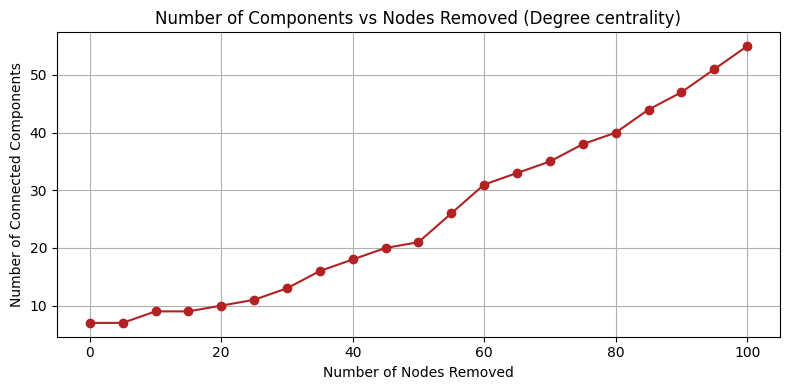

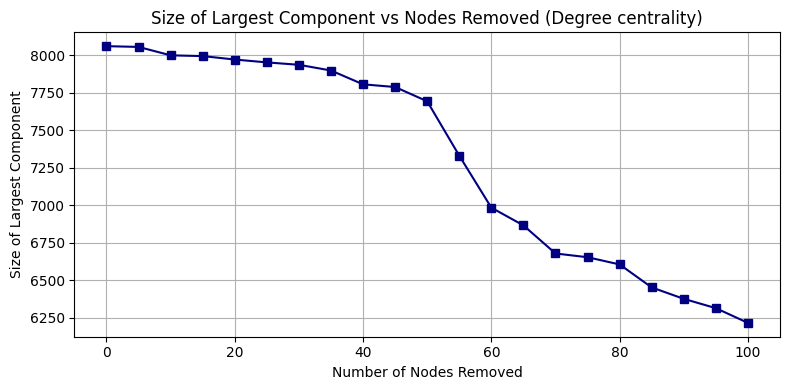

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def simulate_degree_attack(G, centrality_dict, top_n=50, step=5):
    G_temp = G.copy()
    results = []

    # Compute degree centrality
    deg_cent = nx.degree_centrality(G_undirected)

    # Sort nodes by centrality (highest first)
    nodes_ranked = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)

    for i in range(0, top_n + 1, step):
        nodes_to_remove = [node for node, _ in nodes_ranked[:i]]
        G_temp.remove_nodes_from(nodes_to_remove)

        # Analyze fragmentation
        components = list(nx.connected_components(G_temp))
        num_components = len(components)
        largest_size = len(max(components, key=len)) if components else 0

        results.append((i, num_components, largest_size))

        # Reset for next iteration
        G_temp = G.copy()

    return results

# Assuming G_undirected and centrality dict (like deg_cent) already exist
results = simulate_degree_attack(G_undirected, deg_cent, top_n=100, step=5)

x_vals = [r[0] for r in results]
num_components = [r[1] for r in results]
largest_component = [r[2] for r in results]

# Plot 1: Number of Components
plt.figure(figsize=(8, 4))
plt.plot(x_vals, num_components, marker='o', color='firebrick')
plt.title('Number of Components vs Nodes Removed (Degree centrality)')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Number of Connected Components')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Size of Largest Component
plt.figure(figsize=(8, 4))
plt.plot(x_vals, largest_component, marker='s', color='navy')
plt.title('Size of Largest Component vs Nodes Removed (Degree centrality)')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Size of Largest Component')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Betweenness-Based Attack
Betweenness centrality — is often known to identify the most critical "bridging" nodes in a network.

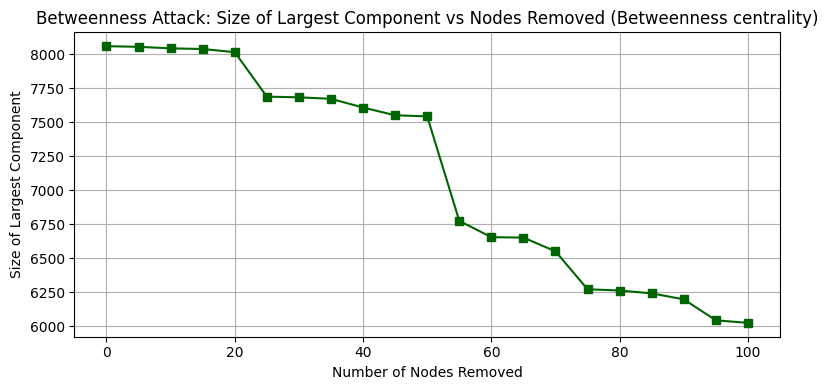

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def simulate_betweenness_attack(G, top_n=50, step=5):
    G_temp = G.copy()
    results = []

    # 1. Compute betweenness centrality
    btw_cent = nx.betweenness_centrality(G)

    # 2. Sort nodes by centrality (highest first)
    nodes_ranked = sorted(btw_cent.items(), key=lambda x: x[1], reverse=True)

    for i in range(0, top_n + 1, step):
        # 3. Remove top-i central nodes
        nodes_to_remove = [node for node, _ in nodes_ranked[:i]]
        G_temp.remove_nodes_from(nodes_to_remove)

        # 4. Compute fragmentation metrics
        components = list(nx.connected_components(G_temp))
        num_components = len(components)
        largest_size = len(max(components, key=len)) if components else 0

        results.append((i, num_components, largest_size))

        # Reset graph
        G_temp = G.copy()

    return results

# Simulate
results_btw = simulate_betweenness_attack(G_undirected, top_n=100, step=5)

# Extract data for plotting
x_vals = [r[0] for r in results_btw]
num_components = [r[1] for r in results_btw]
largest_component = [r[2] for r in results_btw]

# Plot 1: Number of Components
plt.figure(figsize=(8, 4))
plt.plot(x_vals, num_components, marker='o', color='darkorange')
plt.title('Betweenness Attack: Number of Components vs Nodes Removed (Betweenness centrality)')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Number of Connected Components')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Size of Largest Component
plt.figure(figsize=(8, 4))
plt.plot(x_vals, largest_component, marker='s', color='darkgreen')
plt.title('Betweenness Attack: Size of Largest Component vs Nodes Removed (Betweenness centrality)')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Size of Largest Component')
plt.grid(True)
plt.tight_layout()
plt.show()
